In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from numpy.random import choice

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [144]:
df = pd.read_csv('stud_math.csv', encoding="utf-8")

## Первичный осмотр данных

In [145]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [146]:
df.shape

(395, 30)

* В нашем датасете 395 наблюдений с 30 признаками

In [147]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,395.0,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
Medu,392.0,2.750000,1.098127,0.0,2.0,3.0,4.0,4.0
Fedu,371.0,2.614555,2.228732,0.0,2.0,2.0,3.0,40.0
traveltime,367.0,1.438692,0.694181,1.0,1.0,1.0,2.0,4.0
studytime,388.0,2.038660,0.842078,1.0,1.0,2.0,2.0,4.0
failures,373.0,0.337802,0.743135,0.0,0.0,0.0,0.0,3.0
"studytime, granular",388.0,-6.115979,2.526235,-12.0,-6.0,-6.0,-3.0,-3.0
famrel,368.0,3.937500,0.927277,-1.0,4.0,4.0,5.0,5.0
freetime,384.0,3.231771,0.993940,1.0,3.0,3.0,4.0,5.0
goout,387.0,3.105943,1.115896,1.0,2.0,3.0,4.0,5.0


* Видим выбросы в колонках Fedu (max=40.0) и Famrel (min=-1)

* В нашей целевой переменной score наблюдаем сильное различие между медианой (55) и ст. отклонением (22.9), что противоречит нормальности распределения. Позже изучим дискретные признаки подробнее.

In [148]:
df.dtypes

school                  object
sex                     object
age                      int64
address                 object
famsize                 object
Pstatus                 object
Medu                   float64
Fedu                   float64
Mjob                    object
Fjob                    object
reason                  object
guardian                object
traveltime             float64
studytime              float64
failures               float64
schoolsup               object
famsup                  object
paid                    object
activities              object
nursery                 object
studytime, granular    float64
higher                  object
internet                object
romantic                object
famrel                 float64
freetime               float64
goout                  float64
health                 float64
absences               float64
score                  float64
dtype: object

* Проверим, какое количество значений (*cardinality*) принимают наши категориальные переменные

In [309]:
# Занесем все названия категориальных переменных в список
object_cols = [col for col in df.columns if df[col].dtype == "object"]

# У нас также есть кат. переменные с уже закодированными, числовыми значениями. Добавим их в список:
encoded = ["Medu", "Fedu", "traveltime", "studytime", "failures", 
           "famrel", "freetime", "goout", "health"]

for item in encoded:
    object_cols.append(item)

In [311]:
# Сколько уникальных значений принимают наши катег. переменные?
object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Отсортируем кол-во уникальных значений по возрастанию
sorted(d.items(), key=lambda x: x[1])

[('school', 2),
 ('sex', 2),
 ('address', 2),
 ('famsize', 2),
 ('Pstatus', 2),
 ('schoolsup', 2),
 ('famsup', 2),
 ('paid', 2),
 ('activities', 2),
 ('nursery', 2),
 ('higher', 2),
 ('internet', 2),
 ('romantic', 2),
 ('guardian', 3),
 ('reason', 4),
 ('traveltime', 4),
 ('studytime', 4),
 ('failures', 4),
 ('Mjob', 5),
 ('Fjob', 5),
 ('Medu', 5),
 ('freetime', 5),
 ('goout', 5),
 ('health', 5),
 ('Fedu', 6),
 ('famrel', 6)]

* Наблюдаем 13 переменных, принимающих лишь два значения. В целом наши категориальные признаки принимают небольшое число значений, с максимумов 5 (если не учитывать выбросы в *Fedu* & *famrel*), значит мы можем закодировать их, создав dummy-переменные для последующего моделирования.

## Пропуски

In [149]:
df.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

* Во всех признаках, кроме первых трех, наблюдаем выбросы. Изобразим графически:

<AxesSubplot:>

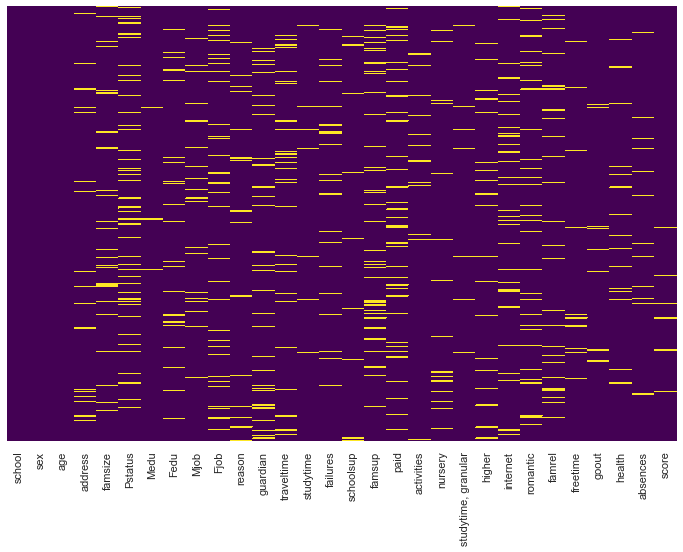

In [313]:
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [151]:
print(f"Процент пропусков от общего числа данных составляет {round((df.isna().sum().sum() / np.prod(df.shape))*100, 2)} %")

Процент пропусков от общего числа данных составляет 4.77 %


In [152]:
df.isna().sum().sort_values(ascending=False)[:6]

Pstatus     45
paid        40
famsup      39
Fjob        36
internet    34
romantic    31
dtype: int64

* Больше всего пропусков наблюдаем в признаках ['Pstatus', 'paid', 'famsup', 'Fjob', 'internet', 'romantic']

In [153]:
print(f"Максимальный процент пропущенных данных от общего числа наблюдений составляет {round(df.isna().sum().sort_values(ascending=False)[:6][0] / df.shape[0]*100, 2)} %")


Максимальный процент пропущенных данных от общего числа наблюдений составляет 11.39 %


* Пропущено 11 и менее процентов от общего количества наблюдений. Удаление столбцов с пропусками считаю неразумным, так как в таком случае мы теряем большой объем потенциально полезных для нашей модели данных.

* Далее поработаем с пропусками в каждом типе переменных.

## Дихотомические переменные (Binary Data)

* В нашем датасете достаточно много дихотомических признаков (переменная принимает лишь два значения). Выделим их в отдельный датафрейм:

In [154]:
bin_var = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup", "famsup", 
           "paid", "activities", "nursery", "higher", "internet", "romantic"]

df_binary = df.loc[:, bin_var]

* Визуализируем эти признаки

[(0.0, 1.0)]

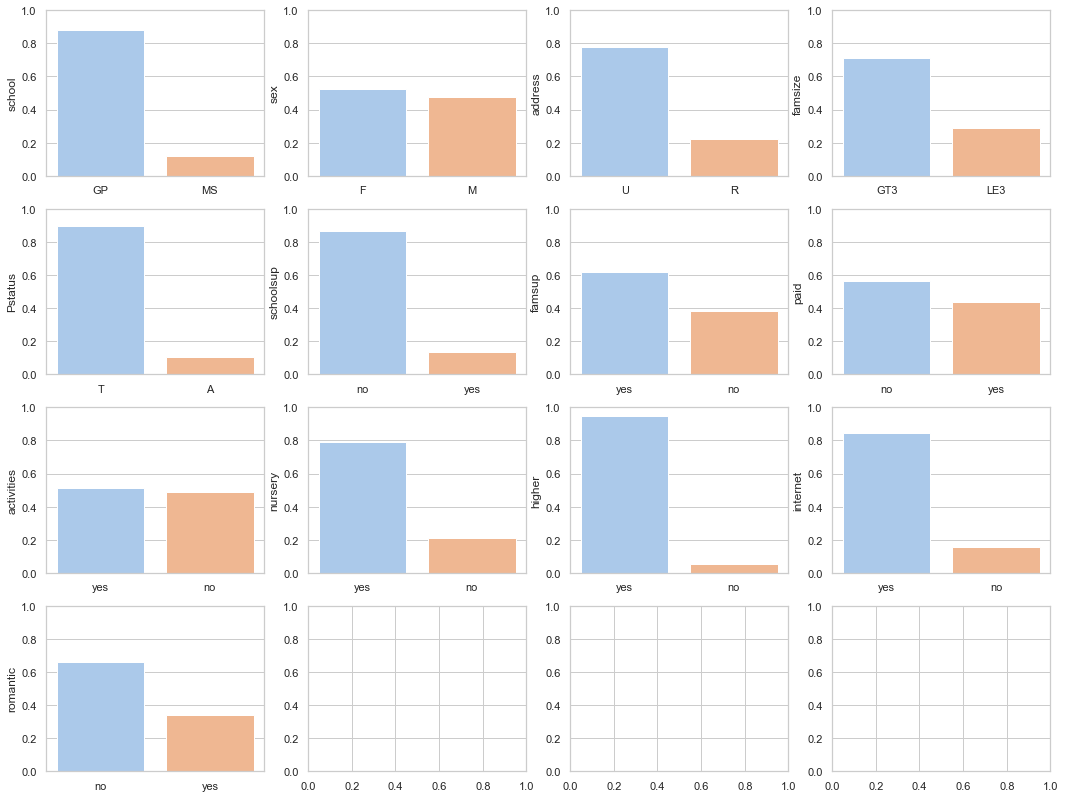

In [172]:
f, ax = plt.subplots(4, 4, figsize=(18,14))

sns.set(style="whitegrid")

f1 = sns.barplot(x = df_binary["school"].value_counts(normalize=True).index, 
                 y = df_binary["school"].value_counts(normalize=True), palette = "pastel", ax=ax[0][0])

f1.set(ylim=(0, 1))

f2 = sns.barplot(x = df_binary["sex"].value_counts(normalize=True).index, 
                 y = df_binary["sex"].value_counts(normalize=True), palette = "pastel", ax=ax[0][1])

f2.set(ylim=(0, 1))

f3 = sns.barplot(x = df_binary["address"].value_counts(normalize=True).index, 
                 y = df_binary["address"].value_counts(normalize=True), palette = "pastel", ax=ax[0][2])

f3.set(ylim=(0, 1))

f4 = sns.barplot(x = df_binary["famsize"].value_counts(normalize=True).index, 
                 y = df_binary["famsize"].value_counts(normalize=True), palette = "pastel", ax=ax[0][3])

f4.set(ylim=(0, 1))

f5 = sns.barplot(x = df_binary["Pstatus"].value_counts(normalize=True).index, 
                 y = df_binary["Pstatus"].value_counts(normalize=True), palette = "pastel", ax=ax[1][0])

f5.set(ylim=(0, 1))

f6 = sns.barplot(x = df_binary["schoolsup"].value_counts(normalize=True).index, 
                 y = df_binary["schoolsup"].value_counts(normalize=True), palette = "pastel", ax=ax[1][1])

f6.set(ylim=(0, 1))

f7 = sns.barplot(x = df_binary["famsup"].value_counts(normalize=True).index, 
                 y = df_binary["famsup"].value_counts(normalize=True), palette = "pastel", ax=ax[1][2])

f7.set(ylim=(0, 1))

f8 = sns.barplot(x = df_binary["paid"].value_counts(normalize=True).index, 
                 y = df_binary["paid"].value_counts(normalize=True), palette = "pastel", ax=ax[1][3])

f8.set(ylim=(0, 1))

f9 = sns.barplot(x = df_binary["activities"].value_counts(normalize=True).index, 
                 y = df_binary["activities"].value_counts(normalize=True), palette = "pastel", ax=ax[2][0])

f9.set(ylim=(0, 1))

f10 = sns.barplot(x = df_binary["nursery"].value_counts(normalize=True).index, 
                  y = df_binary["nursery"].value_counts(normalize=True), palette = "pastel", ax=ax[2][1])

f10.set(ylim=(0, 1))

f11 = sns.barplot(x = df_binary["higher"].value_counts(normalize=True).index, 
                  y = df_binary["higher"].value_counts(normalize=True), palette = "pastel", ax=ax[2][2])

f11.set(ylim=(0, 1))

f12 = sns.barplot(x = df_binary["internet"].value_counts(normalize=True).index, 
                  y = df_binary["internet"].value_counts(normalize=True), palette = "pastel", ax=ax[2][3])

f12.set(ylim=(0, 1))

f13 = sns.barplot(x = df_binary["romantic"].value_counts(normalize=True).index, 
                  y = df_binary["romantic"].value_counts(normalize=True), palette = "pastel", ax=ax[3][0])

f13.set(ylim=(0, 1))


# Безуспешно пытался реализовать это с помощью цикла. Получается только расположив графики вертикально:

# for i in df_binary.columns:
#     bin_num = df_binary[i].value_counts(normalize=False)
#     print("graph for %s" % (i))
#     sns.barplot(x = bin_num.index, y = bin_num)
#     plt.show()


* Как видно из графиков, большинство признаков имеют одно ярко выраженное значение. Исключения составляют признаки *sex* (однако он не имеет пропусков), *famsup*, *paid* и *activities*

* Пропуски в признаках с одним ярко выраженным значением заполним этим значением (*most_frequent*). Для этого воспользуемся методом [SimpleImputer](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation) из библиотеки **sklearn**

In [156]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [173]:
# df_binary -most frequent-
df_binary_mf = df_binary.loc[:, ["school", "address", "famsize", "Pstatus", "schoolsup", 
                                 "nursery", "higher", "internet", "romantic"]]

imp.fit(df_binary_mf)
df_binary_mf_imp = pd.DataFrame(imp.transform(df_binary_mf))

# Imputation убирает название столбцов, вернем их
df_binary_mf_imp.columns = df_binary_mf.columns

In [174]:
# Проверим, ушли ли пропуски
df_binary_mf_imp.isna().sum()

school       0
address      0
famsize      0
Pstatus      0
schoolsup    0
nursery      0
higher       0
internet     0
romantic     0
dtype: int64

* Теперь займемся дихотом. признаками, где значения распределены примерно поровну. Пропуски в них заменим предыдущим значением в столбце:

In [175]:
# df_binary -equal-
df_binary_eq = df_binary.loc[:, ["sex", "famsup", "paid", "activities"]]
df_binary_eq_imp = df_binary_eq.copy(deep=True)

df_binary_eq_imp["famsup"] = df_binary_eq["famsup"].fillna(method="ffill")
df_binary_eq_imp["paid"] = df_binary_eq["paid"].fillna(method="ffill")
df_binary_eq_imp["activities"] = df_binary_eq["activities"].fillna(method="ffill")

In [176]:
df_binary_eq_imp.isna().sum()

sex           0
famsup        0
paid          0
activities    0
dtype: int64

* Объединим получившиеся датафреймы

In [177]:
df_binary_clean = pd.concat([df_binary_eq_imp, df_binary_mf_imp], axis=1)

In [178]:
df_binary_clean.head()

,sex,famsup,paid,activities,school,address,famsize,Pstatus,schoolsup,nursery,higher,internet,romantic
0,F,no,no,no,GP,U,GT3,A,yes,yes,yes,yes,no
1,F,yes,no,no,GP,U,GT3,T,no,no,yes,yes,no
2,F,no,no,no,GP,U,LE3,T,yes,yes,yes,yes,no
3,F,yes,yes,yes,GP,U,GT3,T,no,yes,yes,yes,yes
4,F,yes,yes,no,GP,U,GT3,T,no,yes,yes,no,no


In [179]:
df_binary_clean.isna().sum()

sex           0
famsup        0
paid          0
activities    0
school        0
address       0
famsize       0
Pstatus       0
schoolsup     0
nursery       0
higher        0
internet      0
romantic      0
dtype: int64

* Дихотомические признаки теперь не содержат пропусков. Посмотрим, как теперь они выглядят на графиках.

[(0.0, 1.0)]

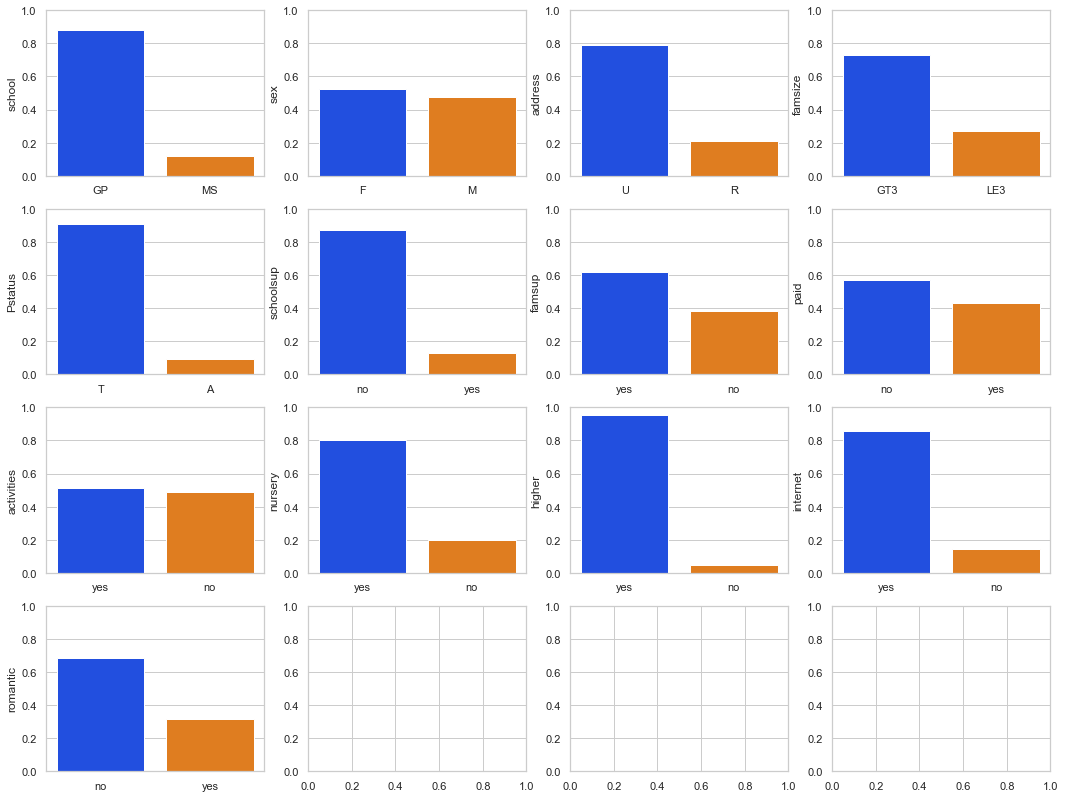

In [299]:
f, ax = plt.subplots(4, 4, figsize=(18,14))

sns.set(style="whitegrid")

f1 = sns.barplot(x = df_binary_clean["school"].value_counts(normalize=True).index, 
                 y = df_binary_clean["school"].value_counts(normalize=True), palette = "bright", ax=ax[0][0])

f1.set(ylim=(0, 1))

f2 = sns.barplot(x = df_binary_clean["sex"].value_counts(normalize=True).index, 
                 y = df_binary_clean["sex"].value_counts(normalize=True), palette = "bright", ax=ax[0][1])

f2.set(ylim=(0, 1))

f3 = sns.barplot(x = df_binary_clean["address"].value_counts(normalize=True).index, 
                 y = df_binary_clean["address"].value_counts(normalize=True), palette = "bright", ax=ax[0][2])

f3.set(ylim=(0, 1))

f4 = sns.barplot(x = df_binary_clean["famsize"].value_counts(normalize=True).index, 
                 y = df_binary_clean["famsize"].value_counts(normalize=True), palette = "bright", ax=ax[0][3])

f4.set(ylim=(0, 1))

f5 = sns.barplot(x = df_binary_clean["Pstatus"].value_counts(normalize=True).index, 
                 y = df_binary_clean["Pstatus"].value_counts(normalize=True), palette = "bright", ax=ax[1][0])

f5.set(ylim=(0, 1))

f6 = sns.barplot(x = df_binary_clean["schoolsup"].value_counts(normalize=True).index, 
                 y = df_binary_clean["schoolsup"].value_counts(normalize=True), palette = "bright", ax=ax[1][1])

f6.set(ylim=(0, 1))

f7 = sns.barplot(x = df_binary_clean["famsup"].value_counts(normalize=True).index, 
                 y = df_binary_clean["famsup"].value_counts(normalize=True), palette = "bright", ax=ax[1][2])

f7.set(ylim=(0, 1))

f8 = sns.barplot(x = df_binary_clean["paid"].value_counts(normalize=True).index, 
                 y = df_binary_clean["paid"].value_counts(normalize=True), palette = "bright", ax=ax[1][3])

f8.set(ylim=(0, 1))

f9 = sns.barplot(x = df_binary_clean["activities"].value_counts(normalize=True).index, 
                 y = df_binary_clean["activities"].value_counts(normalize=True), palette = "bright", ax=ax[2][0])

f9.set(ylim=(0, 1))

f10 = sns.barplot(x = df_binary_clean["nursery"].value_counts(normalize=True).index, 
                  y = df_binary_clean["nursery"].value_counts(normalize=True), palette = "bright", ax=ax[2][1])

f10.set(ylim=(0, 1))

f11 = sns.barplot(x = df_binary_clean["higher"].value_counts(normalize=True).index, 
                  y = df_binary_clean["higher"].value_counts(normalize=True), palette = "bright", ax=ax[2][2])

f11.set(ylim=(0, 1))

f12 = sns.barplot(x = df_binary_clean["internet"].value_counts(normalize=True).index, 
                  y = df_binary_clean["internet"].value_counts(normalize=True), palette = "bright", ax=ax[2][3])

f12.set(ylim=(0, 1))

f13 = sns.barplot(x = df_binary_clean["romantic"].value_counts(normalize=True).index, 
                  y = df_binary_clean["romantic"].value_counts(normalize=True), palette = "bright", ax=ax[3][0])

f13.set(ylim=(0, 1))

## Порядковые переменные (Ordinal Data)

In [184]:
df_ordinal = df.loc[:, ["Medu", "Fedu", "traveltime", "studytime", "failures", 
                        "famrel", "freetime", "goout", "health"]]

* Визуализируем значения наших порядковых переменных:

graph for Medu


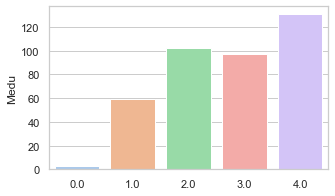

graph for Fedu


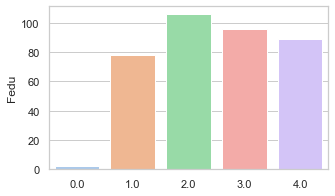

graph for traveltime


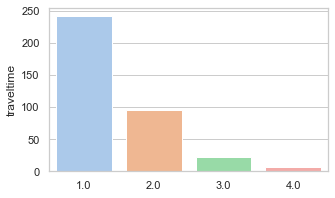

graph for studytime


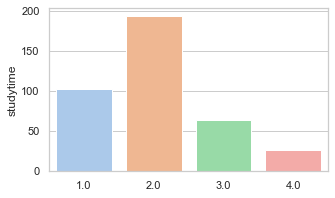

graph for failures


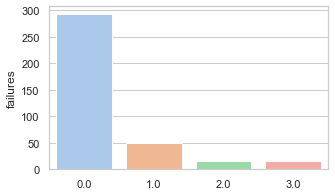

graph for famrel


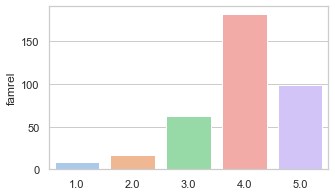

graph for freetime


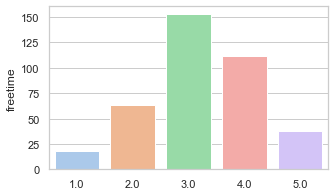

graph for goout


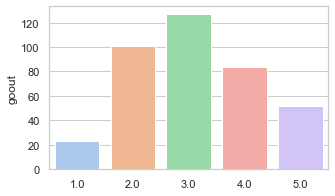

graph for health


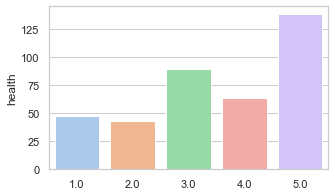

In [298]:
for i in df_ordinal.columns:
    ord_num = df_ordinal[i].value_counts()
    print("graph for %s" % (i))
    plt.subplots(figsize=(5,3))
    sns.set_style("whitegrid")
    sns.barplot(x = ord_num.index, y = ord_num, ci = None, palette = "pastel", orient = 'v')
    plt.show()

* Займемся выбросами в столбцах Fedu и famrel

In [189]:
# Предположу, что значение 40 в столбце Fedu это ошибочно записанное значение 4
df_ordinal["Fedu"] = df_ordinal.Fedu.apply(lambda x: 4.0 if x > 4.0 else x)

In [190]:
df_ordinal["Fedu"].value_counts()

2.0    106
3.0     96
4.0     89
1.0     78
0.0      2
Name: Fedu, dtype: int64

In [191]:
# Предположу, что значение -1 в переменной famrel это ошибочно записанное значение 1
df_ordinal["famrel"] = df_ordinal.famrel.apply(lambda x: 1.0 if x < 1.0 else x)

In [192]:
df_ordinal["famrel"].value_counts()

4.0    182
5.0     99
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64

* Теперь займемся пропусками

In [247]:
df_ordinal.isnull().sum()

Medu           3
Fedu          24
traveltime    28
studytime      7
failures      22
famrel        27
freetime      11
goout          8
health        15
dtype: int64

* На этот раз воспользуемся более сложным подходом [IterativeImputer](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) из **sklearn**, который моделирует каждый признак с пропущенными значениями как функцию других признаков, используя ее для заполнения пропусков.

In [248]:
# multivariate feature imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# в качестве estimator используем DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

In [249]:
imp = IterativeImputer(estimator = DecisionTreeRegressor(), max_iter=10, verbose=0, random_state=0)

In [250]:
imp.fit(df_ordinal)

IterativeImputer(estimator=DecisionTreeRegressor(), random_state=0)

In [251]:
imp.transform(df_ordinal)

array([[4., 4., 2., ..., 3., 4., 3.],
       [1., 1., 1., ..., 3., 3., 3.],
       [1., 1., 1., ..., 3., 2., 3.],
       ...,
       [1., 1., 1., ..., 5., 3., 3.],
       [3., 2., 3., ..., 4., 1., 5.],
       [1., 1., 1., ..., 2., 3., 5.]])

In [252]:
df_ordinal_imp = pd.DataFrame(np.round(imp.transform(df_ordinal)))
df_ordinal_imp.columns = df_ordinal.columns

In [253]:
df_ordinal_imp.isna().sum()

Medu          0
Fedu          0
traveltime    0
studytime     0
failures      0
famrel        0
freetime      0
goout         0
health        0
dtype: int64

In [243]:
# Проверим, остались ли пропуски
df_ordinal_imp.famrel.value_counts()

4.0    197
5.0    105
3.0     64
2.0     19
1.0     10
Name: famrel, dtype: int64

In [255]:
# Видим, что 27 пропущенных значений признака famrel были распределены среди всех значений признака,
# руководствуясь логикой модели DecisionTreeRegressor
df_ordinal.famrel.value_counts(dropna=False)

4.0    182
5.0     99
3.0     62
NaN     27
2.0     17
1.0      8
Name: famrel, dtype: int64

* Еще раз визуализируем обновленные признаки

graph for Medu


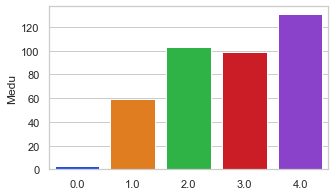

graph for Fedu


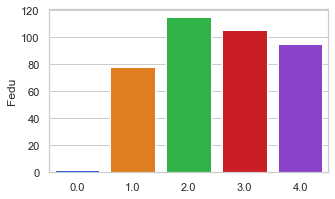

graph for traveltime


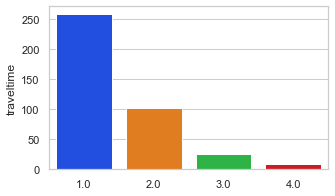

graph for studytime


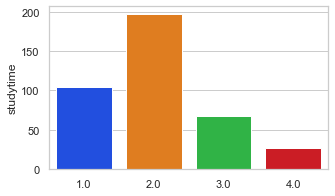

graph for failures


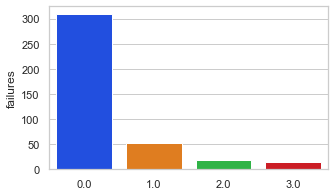

graph for famrel


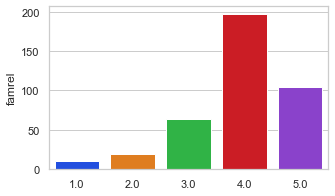

graph for freetime


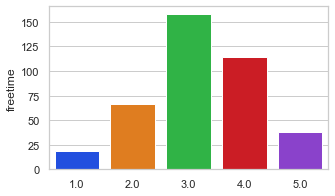

graph for goout


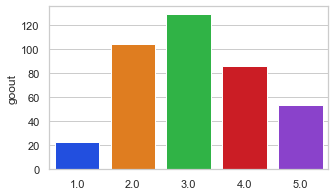

graph for health


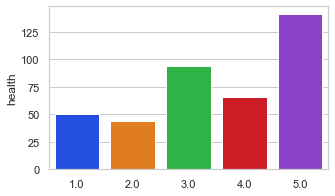

In [297]:
for i in df_ordinal_imp.columns:
    ord_num = df_ordinal_imp[i].value_counts()
    print("graph for %s" % (i))
    plt.subplots(figsize=(5,3))
    sns.set_style("whitegrid")
    sns.barplot(x = ord_num.index, y = ord_num, ci = None, palette = "bright", orient = 'v')
    plt.show()

## Номинальные переменные (Nominal Data)

In [264]:
# создадим датафрейм для наших номинальных переменных
df_nominal = df.loc[:, ["Mjob", "Fjob", "reason", "guardian"]]

* Визуализируем номинальне переменные

graph for Mjob


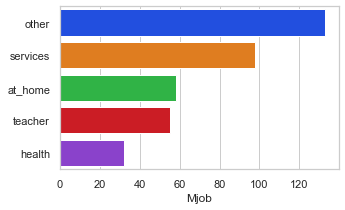

graph for Fjob


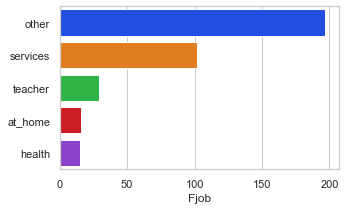

graph for reason


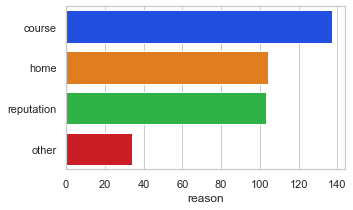

graph for guardian


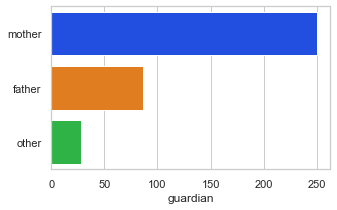

In [295]:
for i in df_nominal.columns:
    nom_num = df_nominal[i].value_counts()
    print("graph for %s" % (i))
    plt.subplots(figsize=(5,3))
    sns.set_style("whitegrid")
    sns.barplot(x = nom_num, y = nom_num.index, ci = None, palette = "bright", orient = 'h')
    plt.show()

* Займемся пропусками

In [265]:
df_nominal.isnull().sum()

Mjob        19
Fjob        36
reason      17
guardian    31
dtype: int64

* Пропуски заполним значениями переменной, взвешенными по вероятностям их появления в признаке (*value_counts(normalize=True)*)

In [277]:
def mjob_fill(row):
    elements = df_nominal.Mjob.value_counts().index.to_list() # возможные знач-я переменной
    weights = df_nominal.Mjob.value_counts(normalize=True).tolist() # вероятности (веса) появления значения в признаке
    if pd.isnull(row.Mjob):
        return choice(elements, p=weights)
    return row.Mjob

In [278]:
df_nominal_imp = df_nominal.copy(deep=True)

In [279]:
df_nominal_imp["Mjob"] = df_nominal_imp.apply(mjob_fill, axis=1)

In [280]:
df_nominal_imp["Mjob"].isna().sum()

0

In [283]:
def fjob_fill(row):
    elements = df_nominal.Fjob.value_counts().index.to_list() # возможные знач-я переменной
    weights = df_nominal.Fjob.value_counts(normalize=True).tolist() # вероятности (веса) появления значения в признаке
    if pd.isnull(row.Fjob):
        return choice(elements, p=weights)
    return row.Fjob

In [284]:
df_nominal_imp["Fjob"] = df_nominal_imp.apply(fjob_fill, axis=1)

In [285]:
df_nominal_imp["Fjob"].isna().sum()

0

In [286]:
def reason_fill(row):
    elements = df_nominal.reason.value_counts().index.to_list()
    weights = df_nominal.reason.value_counts(normalize=True).tolist()
    if pd.isnull(row.reason):
        return choice(elements, p=weights)
    return row.reason

In [288]:
df_nominal_imp["reason"] = df_nominal_imp.apply(reason_fill, axis=1)

In [289]:
df_nominal_imp["reason"].isna().sum()

0

In [290]:
def guardian_fill(row):
    elements = df_nominal.guardian.value_counts().index.to_list()
    weights = df_nominal.guardian.value_counts(normalize=True).tolist()
    if pd.isnull(row.guardian):
        return choice(elements, p=weights)
    return row.guardian

In [291]:
df_nominal_imp["guardian"] = df_nominal_imp.apply(guardian_fill, axis=1)

In [293]:
df_nominal_imp.isna().sum()

Mjob        0
Fjob        0
reason      0
guardian    0
dtype: int64

* Еще раз визуализируем результаты

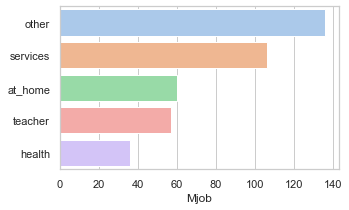

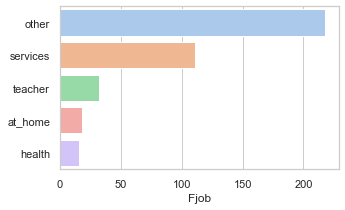

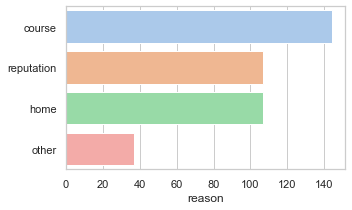

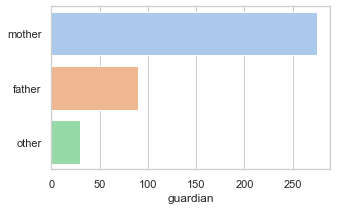

In [294]:
for i in df_nominal_imp.columns:
    nom_num = df_nominal_imp[i].value_counts()
    plt.subplots(figsize=(5,3))
    sns.set_style("whitegrid")
    sns.barplot(x = nom_num, y = nom_num.index, ci = None, palette = "pastel", orient = 'h')
    plt.show()

In [ ]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=cacao.loc[cacao.loc[:, column].isin(cacao.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [ ]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_boxplot(col)